# Convolutional NN

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from d2l import torch as d2l

## You start!

Write your own convolutional operation based on what expleained in class. Here some reminders:
- X is the input matrix
- K is the kernel (filter)
- Y is the output matrix 

Suggested Steps:
- Define an empty matrix Y with the correct shape
- fill in the matrix, element-by-element, with the result of the convolution operation between X and K


In [ ]:
def corr2d(X, K):  #@save
    h, w = K.shape
    Y = torch.zeros(X.shape[0] - h + 1, X.shape[1] - w + 1 )
    # input size 3x3, n_h, k_h
    # kernel size 2x2, k_h, k_w
    
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()

    return Y

The next steps will make use of this function you created!

In [11]:
# define a generic X tensor and a kernel K
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
print(len(X), X.shape)

3 torch.Size([3, 3])


In [12]:
Y = corr2d(X, K)
Y

tensor([[19., 25.],
        [37., 43.]])

In [13]:
# Test your function
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

If you wrote the function correctly, you should get the following  Y tensor

`tesor([[19, 25],[37, 43]])`

## Convolutional Layers

A convolutional layer cross-correlates the input and kernel and adds a scalar bias to produce an output. 

The two parameters of a convolutional layer are the kernel and the scalar bias. We typically initialize the kernels randomly, just as we would with a fully connected layer.

In [14]:
class Conv2D(nn.Module):
    
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias   # X = input, kernel = weight


### Object Edge Detection in Images

Let’s take a moment to parse a simple application of a convolutional layer: detecting the edge of an object in an image by finding the location of the pixel change.

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])


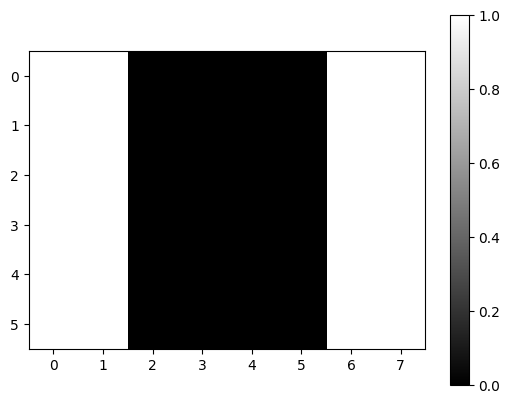

In [15]:
# first, contruct an image X: middle four columns are black (0) and the rest are white (1)
X = torch.ones((6, 8))
X[:, 2:6] = 0
print(X)

plt.imshow(X, cmap='gray')
plt.colorbar()
plt.show()


tensor([[ 1, -1]])


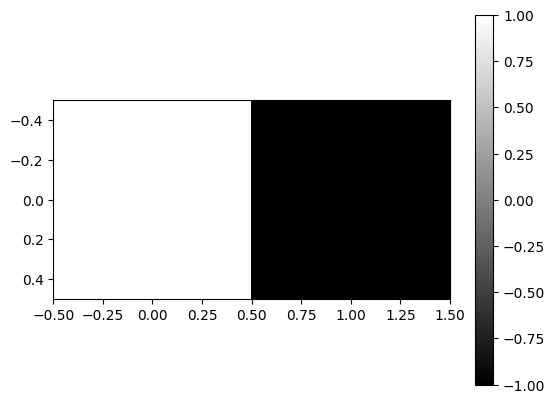

In [16]:
# Next, we construct a kernel K with a height of 1 and a width of 2. 
# When we perform the cross-correlation operation with the input, 
# if the horizontally adjacent elements are the same, the output is 0. 
# Otherwise, the output is nonzero.
K = torch.tensor([[1, -1]])
print(K)

plt.imshow(K, cmap='gray')
plt.colorbar()
plt.show()

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])


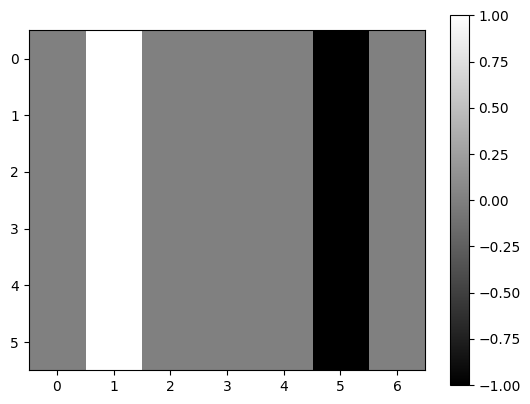

In [17]:
# Now we can use the kernel K to detect the vertical edges of the object in the input X.
Y = corr2d(X, K)
print(Y)

plt.imshow(Y, cmap='gray')
plt.colorbar()
plt.show()

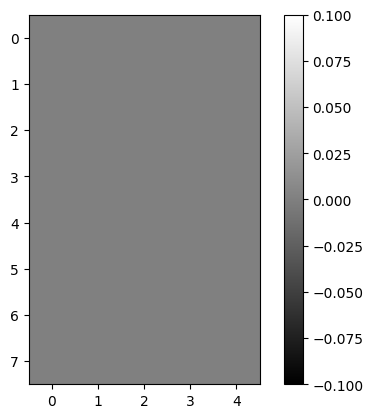

In [18]:
# We can now apply the kernel to the transposed image. 
# As expected, it vanishes. The kernel K only detects vertical edges.
corr2d(X.t(), K)

plt.imshow(corr2d(X.t(), K), cmap='gray')
plt.colorbar()
plt.show()

In [21]:
Y.shape

torch.Size([1, 1, 6, 7])

## Our Goals: Learning a Kernel

Designing an edge detector by finite differences [1, -1] is neat if we know this is precisely what we are looking for. However, as we look at larger kernels, and consider successive layers of convolutions, it might be impossible to specify precisely what each filter should be doing manually.


In [ ]:
# Construct a two-dimensional convolutional layer with 1 output channel and a
# kernel of shape (1, 2). For the sake of simplicity, we ignore the bias here
conv2d = nn.LazyConv2d(1, kernel_size=(1, 2), bias=False)
# 1 = number of feature maps 
# LazyConv2d = lazy linear kernel
# start with kernel 1x2 

# The two-dimensional convolutional layer uses four-dimensional input and
# output in the format of (example, channel, height, width), where the batch
# size (number of examples in the batch) and the number of channels are both 1
X = X.reshape((1, 1, 6, 8)) # 1 = examples, 1 = channels, 6x8 images
Y = Y.reshape((1, 1, 6, 7)) 
lr = 3e-2  # Learning rate

for i in range(10): # epochs = 10
    # make the prediction
    Y_hat = conv2d(X)
    # compute the loss
    l = (Y_hat - Y) ** 2    # difference of pred and true squared
    # compute the gradient; initialize to zero
    conv2d.zero_grad() # Zero the gradients before running the backward pass.
    l.sum().backward()
    # Update the kernel or weight
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i + 1}, loss {l.sum():.3f}')


epoch 2, loss 3.043
epoch 4, loss 0.935
epoch 6, loss 0.331
epoch 8, loss 0.127
epoch 10, loss 0.050


/opt/anaconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Note that the error has dropped to a small value after 10 iterations. Now we will take a look at the kernel tensor we learned.


In [20]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 1.0170, -0.9711]])

## Exercises

### Es 1

What if such layers perform strict convolution operations (in the mathematical sense) instead of cross-correlations? 

How do you need to change the kernel (or the input tensor) in order to test this?

# Padding

In [22]:
# We define a helper function to calculate convolutions. It initializes the
# convolutional layer weights and performs corresponding dimensionality
# elevations and reductions on the input and output

def comp_conv2d(conv2d, X):
    # (1, 1) indicates that batch size and the number of channels are both 1
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # Strip the first two dimensions: examples and channels
    return Y.reshape(Y.shape[2:])


In [23]:
# 1 row and column is padded on either side, so a total of 2 rows or columnsare added
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

/opt/anaconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([8, 8])

When the height and width of the convolution kernel are different, we can make the output and input have the same height and width by setting different padding numbers for height and width.

In [24]:
# We use a convolution kernel with height 5 and width 3. The padding on either
# side of the height and width are 2 and 1, respectively
conv2d = nn.LazyConv2d(1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

# Stride

In [27]:
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape


torch.Size([4, 4])

In [28]:
# Let’s look at a slightly more complicated example.
conv2d = nn.LazyConv2d(1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

# Multiple Input Channels

In [ ]:
def corr2d_multi_in(X, K):
    # Iterate through the 0th dimension (channel) of K first, then add them up
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))


In [ ]:

X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])
corr2d_multi_in(X, K)


# Multiple Output Channels

In [ ]:
def corr2d_multi_in_out(X, K):
    # Iterate through the 0th dimension of K, and each time, perform
    # cross-correlation operations with input X. All of the results are
    # stacked together
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

K = torch.stack((K, K + 1, K + 2), 0)
K.shape

In [ ]:
corr2d_multi_in_out(X, K)

# this creates 3 feature maps in output!

# 1x1 Convolutional layer

In [ ]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    # Matrix multiplication in the fully connected layer
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

In [ ]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))
Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

# Pooling

Returning to the problem of edge detection, we use the output of the convolutional layer as input for 2 × 2 max-pooling. Denote by X the input of the convolutional layer input and Y the pooling layer output. Regardless of whether or not the values of X[i, j], X[i, j + 1], X[i+1, j] and X[i+1, j + 1] are different, the pooling layer always outputs Y[i, j] = 1. That is to say, using the 2 × 2 max-pooling layer, we can still detect if the pattern recognized by the convolutional layer moves no more than one element in height or width.

In [ ]:
def pool2d(X, pool_size, mode='max'):
    
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    
    return Y

In [ ]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))


In [ ]:
pool2d(X, (2, 2), 'avg')


We can demonstrate the use of padding and strides in pooling layers via the built-in two-dimensional max-pooling layer from the deep learning framework.

NOTE: Since pooling aggregates information from an area, deep learning frameworks default to matching pooling window sizes and stride. For instance, if we use a pooling window of shape (3, 3) we get a stride shape of (3, 3) by default.

In [ ]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X


In [ ]:
pool2d = nn.MaxPool2d(3)
# by default stride = pool size
# Pooling has no model parameters, hence it needs no initialization
pool2d(X)


In [ ]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)


In [ ]:
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)


In [ ]:
# let's see what happens for multiple channels

X = torch.cat((X, X + 1), 1)
X

In [ ]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

# Transpose Convolution

Ignoring channels for now, let’s begin with the basic transposed convolution operation with
stride of 1 and no padding. 

Suppose that we are given a $𝑛_ℎ \times 𝑛_𝑤$ input tensor and a $𝑘_ℎ \times 𝑘_𝑤$
kernel. 

Procedure:
*  Sliding the kernel window with stride of 1 --> we get  $𝑛_ℎ \times 𝑛_𝑤$ intermediate results
*  Each intermediate result is a ($𝑛_ℎ + 𝑘_ℎ − 1) \times (𝑛_𝑤 + 𝑘_𝑤 − 1)$ tensor that are initialized as zeros
*  Each element in the input tensor is multiplied by the kernel so that the resulting $𝑘_ℎ \times 𝑘_𝑤$ tensor replaces a portion in each intermediate tensor.
*  All intermetiate results are summed over to produce the output


In [ ]:
def trans_conv(X, K):
    h, w = K.shape
    Y = torch.zeros((X.shape[0] + h - 1, X.shape[1] + w - 1))
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Y[i: i + h, j: j + w] += X[i, j] * K
    return Y

In [ ]:
X = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
trans_conv(X, K)

Alternatively, when the input Xand kernel Kare both fourth-order tensors, we can use high-level APIs to obtain the same results.

In [ ]:
X, K = X.reshape(1, 1, 2, 2), K.reshape(1, 1, 2, 2)
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, bias=False)
tconv.weight.data = K
tconv(X)

## Padding, Strides, and Multiple Channels

Different from in the regular convolution where padding is applied to input, it is applied to
output in the transposed convolution. 

For example, when specifying the padding number
on either side of the height and width as 1, the first and last rows and columns will be
__removed__ from the transposed convolution output.

In [ ]:
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, padding=1, bias=False)
tconv.weight.data = K
tconv(X)

In the transposed convolution, strides are specified for intermediate results (thus output),
not for input.

Changing the stride from 1 to 2 increases both the height and width of intermediate tensors.

In [ ]:
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, stride=2, bias=False)
tconv.weight.data = K
tconv(X)

For multiple input and output channels, the transposed convolution works in the same way
as the regular convolution.

When multiple output
channels are specified, we will have a 𝑐𝑖 × 𝑘ℎ × 𝑘𝑤 kernel for each output channel.

In [ ]:
X = torch.rand(size=(1, 10, 16, 16))
conv = nn.Conv2d(10, 20, kernel_size=5, padding=2, stride=3)
tconv = nn.ConvTranspose2d(20, 10, kernel_size=5, padding=2, stride=3)
tconv(conv(X)).shape == X.shape